Imports holistic vectors and argument vectors for verbs and performs ridge regression to train verb matrices.

This file is intended to tune parameters and evaluate training. Matrices are not exported. There is also the option to use a subset of all verbs, and data is split into 80% train and 20% test data.

In [50]:
import numpy as np
from reach import Reach
import sklearn
import sklearn.linear_model
from numpy import linalg as la
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import sklearn.preprocessing

np.random.seed(0)
#pathnames
indexpath = './verbtrainingindex_withweights.npy'
holmatrixpath = './cooccurrence/svd/newmatrix.npy'
embeddingspath = './tulkens-embeddings/160/sonar-160.txt'
figpath = './figures'



In [ ]:
#import data
index = np.load(indexpath)
holmatrix = np.load(holmatrixpath)
arg_data = Reach(embeddingspath, header=True)

In [116]:
#parameters
n_dim = 160
s_dim = 200
alpha_values = []
#alpha_values += [0.01, 0.5, 0.1, 0.5, 1]
#alpha_values += [5, 10, 25, 50, 75, 100, 500]
#alpha_values += [500, 1000, 5000]
#alpha_values += [10000, 50000]
alpha_values += [0.005]
min_sample_size = 20
variance_control = True
mean_std = 0.08

In [60]:
#create subset of complete verb index for testing
selection = np.random.choice(range(2,len(index)), size=240, replace=False)
miniindex = np.array(['', [0, '']], object)
for i in selection:
    miniindex = np.vstack([miniindex, index[i]])

In [61]:
#get actual sample size, with N > 500
t = 0
for row in miniindex:
    if len(row[0]) >= 1:
        samples = row[1]
        samplesize = samples.shape[0]
        if samplesize > min_sample_size:
            t += 1

print(len(miniindex), 'total,', t, 'counted')

241 total, 218 counted


In [19]:
#get indication of normal variance within arguments
stds = list()
scaled_stds = list()

#loop through verbs
for row in tqdm(index):
    if len(row[0]) >= 1:
        verb = row[0]
        samples = row[1]

        # randomly select train an test data
        samplesize = samples.shape[0]
        if samplesize > min_sample_size:            
            for i in range(samplesize):
                sample = samples[i]
                # samples are of form holmatrixrow, argstring, weight
                if sample[1] != '':
                    # import of vectors
                    arg_v = arg_data.vector(sample[1])
                    
                    scaler = sklearn.preprocessing.StandardScaler()
                    scaled_arg_v = scaler.fit_transform(arg_v[:, np.newaxis])
                    scaled_arg_v = np.squeeze(scaled_arg_v)
                    scaled_arg_v = 0.1 * scaled_arg_v

                    #get stds
                    std = np.std(arg_v)
                    scaled_std = np.std(scaled_arg_v)
                    stds.append(std)
                    scaled_stds.append(scaled_std)

print(np.mean(stds))
print(np.mean(scaled_stds))



0.0787885
0.09999994


In [106]:
#reset evaluation record
evals = dict()

In [117]:
for alpha_value in tqdm(alpha_values):
    #for evaluation summary
    verbs_overall = []
    sizes_overall = []
    R2s_overall_av = []
    R2s_overall_med = []
    R2s_train_overall_av = []
    R2s_train_overall_med = []
    eval_train = True # whether you want to evaluate on training data as well as test data

    #loop through verbs
    for row in tqdm(miniindex):
        if len(row[0]) >= 1:
            verb = row[0]
            samples = row[1]
            #containers for train and test data
            hol_vs = {'train': np.zeros((1, s_dim)), 'test': np.zeros((1, s_dim))}
            arg_vs = {'train': np.zeros((1, n_dim)), 'test': np.zeros((1, n_dim))}
            weights = {'train': np.array([0.0]), 'test': np.array([0.0])}

            # randomly select train an test data
            samplesize = samples.shape[0]
            if samplesize > min_sample_size:            
                trainindices = sorted(list(np.random.choice(range(samplesize), size=int(0.8*samplesize), replace=False)))

                # load vectors into train and test collections
                for i in range(samplesize):
                    dest = ''
                    if len(trainindices) > 0 and trainindices[0] == i:
                        dest = 'train'
                        trainindices = trainindices[1:]
                    else:
                        dest = 'test'
                    sample = samples[i]
                    # samples are of form holmatrixrow, argstring, weight
                    if sample[1] != '':
                        # import of vectors
                        hol_v = holmatrix[int(sample[0])]
                        arg_v = arg_data.vector(sample[1])
                        weight = float(sample[2])
                        
                        #apply standard scaling
                        scaler = sklearn.preprocessing.StandardScaler()
                        scaler.set_params(with_std=variance_control)
                        arg_v = scaler.fit_transform(arg_v[:, np.newaxis])
                        arg_v = np.squeeze(arg_v)
                        if variance_control:
                            arg_v = mean_std * arg_v #to make sure the effect of variance control is not an effect of scale
                        
                        #store holistic vector
                        if np.array_equal(hol_vs[dest], np.zeros((1, s_dim))):
                            hol_vs[dest] = np.array([hol_v])
                        else:
                            hol_vs[dest] = np.vstack([hol_vs[dest], hol_v])
                        #store argument vector
                        if np.array_equal(arg_vs[dest], np.zeros((1, n_dim))):
                            arg_vs[dest] = np.array([arg_v])
                        else:
                            arg_vs[dest] = np.vstack([arg_vs[dest], arg_v])
                        #store weight
                        if np.array_equal(weights[dest], np.array([0.0])):
                            weights[dest] = np.array([weight])
                        else:
                            weights[dest] = np.hstack([weights[dest], np.array([weight])])                    

                # train matrix
                verb_m = np.zeros((n_dim, s_dim))
                R2s = np.zeros(s_dim)
                R2s_train = np.zeros(s_dim)
                #train one column of the matrix
                for i in range(s_dim): #s_dim
                    model = sklearn.linear_model.Ridge(alpha=alpha_value, fit_intercept=False)
                    model.fit(arg_vs['train'], hol_vs['train'][:, i, np.newaxis], sample_weight=weights['train'])
                    verb_m[:, i] = model.coef_

                    #evaluate matrix row
                    estimated = model.predict(arg_vs['test'])
                    real = hol_vs['test'][:,0]
                    R2 = model.score(arg_vs['test'], hol_vs['test'][:, i, np.newaxis], sample_weight=weights['test'])
                    R2s[i] = R2.copy()

                    if eval_train:
                        R2_train = model.score(arg_vs['train'], hol_vs['train'][:, i], sample_weight=weights['train'])
    #                     R2s_train.append(R2_train)
                        R2s_train[i] = R2_train.copy()

                # evaluate entire matrix
                verbs_overall.append(verb)
                sizes_overall.append(samplesize)
                R2s_overall_av.append(np.mean(R2s))
                R2s_train_overall_av.append(np.mean(R2s_train))
                R2s_overall_med.append(np.median(R2s))
                R2s_train_overall_med.append(np.median(R2s_train))
        
    evals[alpha_value] = {'Med R2 (test)': np.median(R2s_overall_med), 'Med R2 (train)': np.median(R2s_train_overall_med), 'plotdata': {'sizes': sizes_overall.copy(), 'testeval': R2s_overall_med.copy(), 'traineval': R2s_train_overall_med.copy() } }

In [144]:
#restore font settings because i fucked with them
import matplotlib
matplotlib.rcdefaults()

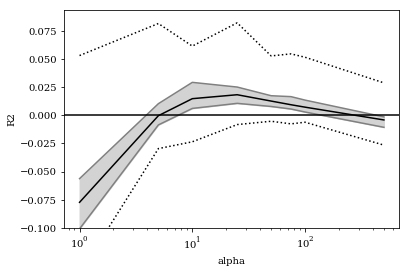

In [52]:
alpha_compare = list()
for a in sorted(evals.keys()):
    data = evals[a]['plotdata']['testeval']
    alpha_compare.append((a, min(data), np.percentile(data, 25), np.median(data), np.percentile(data, 75), max(data)))

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'Times', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'DejaVu Serif', 'serif']

plt.plot(
        [i[0] for i in alpha_compare], [i[4] for i in alpha_compare], 'gray',
        [i[0] for i in alpha_compare], [i[3] for i in alpha_compare], 'black',
        [i[0] for i in alpha_compare], [i[2] for i in alpha_compare], 'gray')

plt.plot([i[0] for i in alpha_compare], [i[5] for i in alpha_compare], 'black', 
         [i[0] for i in alpha_compare], [i[1] for i in alpha_compare], 'black', 
         linestyle='dotted')

plt.fill_between([i[0] for i in alpha_compare], [i[4] for i in alpha_compare],[i[2] for i in alpha_compare], color='#D3D3D3')

plt.semilogx()
plt.ylim(bottom=-0.1)
plt.axhline(color='k')
plt.xlabel('alpha'); plt.ylabel('R2')
#plt.title('Scores at different alpha values')

plt.savefig(figpath+'/alpha.eps', transparent=True)

In [118]:
#alpha value to look at in more detail
eval_alpha = 0.005

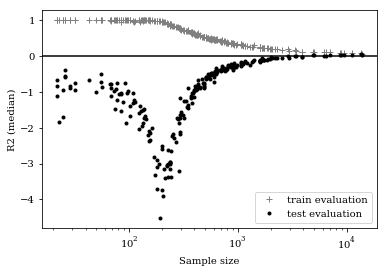

In [119]:
plt.plot(evals[eval_alpha]['plotdata']['sizes'], evals[eval_alpha]['plotdata']['traineval'], '+', color='gray')
plt.plot(evals[eval_alpha]['plotdata']['sizes'], evals[eval_alpha]['plotdata']['testeval'], '.', color='black')

plt.semilogx(); plt.axhline(color='k')
#plt.ylim(bottom=-0.1)
plt.xlabel('Sample size')
plt.ylabel('R2 (median)')
plt.legend(['train evaluation', 'test evaluation'])

plt.savefig(figpath+'/evaluation_samplesize_alpha'+str(eval_alpha)+'_std'+str(variance_control)+'.eps', transparent=True)